# Python: Coniditional Value at Risk of potential outcomes
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the conditional Value at Risk of potential outcomes. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

The data is generated as a location-scale model with

$$Y_i = \text{loc}(D_i,X_i) + \text{scale}(D_i,X_i)\cdot\varepsilon_i,$$

where $X_i\sim\mathcal{U}[-1,1]^{p}$, $D_i\sim \mathcal{B}(1,1/2)$ and $\varepsilon_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{loc}(d,x) &:= 0.3d + 4dx_4x_1 - 3x_3 \\
\text{scale}(d,x) &:= \sqrt{d/2 + 3dx_1 + 1},
\end{aligned}$$

and the treatment takes the following form

$$D_i = 1_{\{(X_2 - X_3 + \epsilon_i > 0)\}}$$

with $\epsilon_i \sim \mathcal{N}(0,1)$.

In [2]:
def f_loc(D, X):
  loc = 0.3*D + 4*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return loc

def f_scale(D, X):
  scale = np.sqrt(1*D + 2*D*X[:,1] + 1)
  return scale

def dgp(n=200, p=5):
    X = np.random.uniform(-1,1,size=[n,p])
    D = ((X[:,1 ] - X[:,3] + np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

We can calculate the true conditional value at risk through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.1,0.95,0.05)
p = 10
n_true = int(10e+6)

_, X_true, _, epsilon_true = dgp(n=n_true, p = p)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

Y1_cvar = [Y1[Y1 >= quant].mean() for quant in Y1_quant]
Y0_cvar = [Y0[Y0 >= quant].mean() for quant in Y0_quant]

print(f'Conditional Value at Risk Y(0): {Y0_cvar}')
print(f'Conditional Value at Risk Y(1): {Y1_cvar}')

Conditional Value at Risk Y(0): [0.37274693875935694, 0.5376308466670315, 0.6988686286288297, 0.8585514756246003, 1.0179062347754677, 1.1777672237929393, 1.3387788691284805, 1.501514802836262, 1.6667086772376432, 1.835208855938224, 2.0081795412955517, 2.1872804786197264, 2.3750505333328853, 2.575484145730803, 2.795190101262318, 3.0462964143554645, 3.354687990652136]
Conditional Value at Risk Y(1): [0.9814126951400899, 1.2558709269981063, 1.5170140669380219, 1.77157063261202, 2.0237006275242635, 2.2765719584343365, 2.5328994534112215, 2.795271677737039, 3.0664350304207115, 3.3498147979178046, 3.6494862252720446, 3.9710453882213215, 4.322552215009152, 4.715842171572239, 5.170272028917805, 5.720194123618059, 6.439599304894886]


Let us generate $n=1000$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [4]:
n = 1000
p = 5

np.random.seed(42)
Y, X, D, _ = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

## Conditional Value at Risk (CVaR)
Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLCVAR` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [5]:
ml_m = RandomForestClassifier(n_estimators=200)
ml_g = RandomForestClassifier(n_estimators=200)



CVAR_0 = np.full((len(tau_vec)), np.nan)
CVAR_1 = np.full((len(tau_vec)), np.nan)

ci_CVAR_0 = np.full((len(tau_vec),2), np.nan)
ci_CVAR_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_CVAR_0 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=0,
                                n_folds=5)
    dml_CVAR_1 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=1,
                                n_folds=5)

    dml_CVAR_0.fit()
    dml_CVAR_1.fit()

    ci_CVAR_0[idx_tau, :] = dml_CVAR_0.confint(level=0.95).to_numpy()
    ci_CVAR_1[idx_tau, :] = dml_CVAR_1.confint(level=0.95).to_numpy()

    CVAR_0[idx_tau] = dml_CVAR_0.coef
    CVAR_1[idx_tau] = dml_CVAR_1.coef

Quantile: 0.1
Quantile: 0.15000000000000002
Quantile: 0.20000000000000004
Quantile: 0.25000000000000006
Quantile: 0.30000000000000004
Quantile: 0.3500000000000001
Quantile: 0.40000000000000013
Quantile: 0.45000000000000007
Quantile: 0.5000000000000001
Quantile: 0.5500000000000002
Quantile: 0.6000000000000002
Quantile: 0.6500000000000001
Quantile: 0.7000000000000002
Quantile: 0.7500000000000002
Quantile: 0.8000000000000002
Quantile: 0.8500000000000002
Quantile: 0.9000000000000002


Finally, let us take a look at the estimated values.

In [6]:
data = {"Quantile": tau_vec, "CVaR Y(0)": Y0_cvar, "CVaR Y(1)": Y1_cvar,
        "DML CVaR Y(0)": CVAR_0, "DML CVaR Y(1)": CVAR_1,
        "DML CVaR Y(0) lower": ci_CVAR_0[:, 0], "DML CVaR Y(0) upper": ci_CVAR_0[:, 1],
        "DML CVaR Y(1) lower": ci_CVAR_1[:, 0], "DML CVaR Y(1) upper": ci_CVAR_1[:, 1]}
df = pd.DataFrame(data)
print(df)

    Quantile  CVaR Y(0)  CVaR Y(1)  DML CVaR Y(0)  DML CVaR Y(1)  \
0       0.10   0.372747   0.981413       0.402146       0.923113   
1       0.15   0.537631   1.255871       0.385928       1.094065   
2       0.20   0.698869   1.517014       0.601610       1.142731   
3       0.25   0.858551   1.771571       0.797331       1.653433   
4       0.30   1.017906   2.023701       0.881134       1.833344   
5       0.35   1.177767   2.276572       1.097953       2.096988   
6       0.40   1.338779   2.532899       1.200685       2.319370   
7       0.45   1.501515   2.795272       1.261211       2.520283   
8       0.50   1.666709   3.066435       1.574061       2.799580   
9       0.55   1.835209   3.349815       1.724443       3.119003   
10      0.60   2.008180   3.649486       1.809993       3.370586   
11      0.65   2.187280   3.971045       1.978819       3.651538   
12      0.70   2.375051   4.322552       2.295349       4.016379   
13      0.75   2.575484   4.715842       2.55289

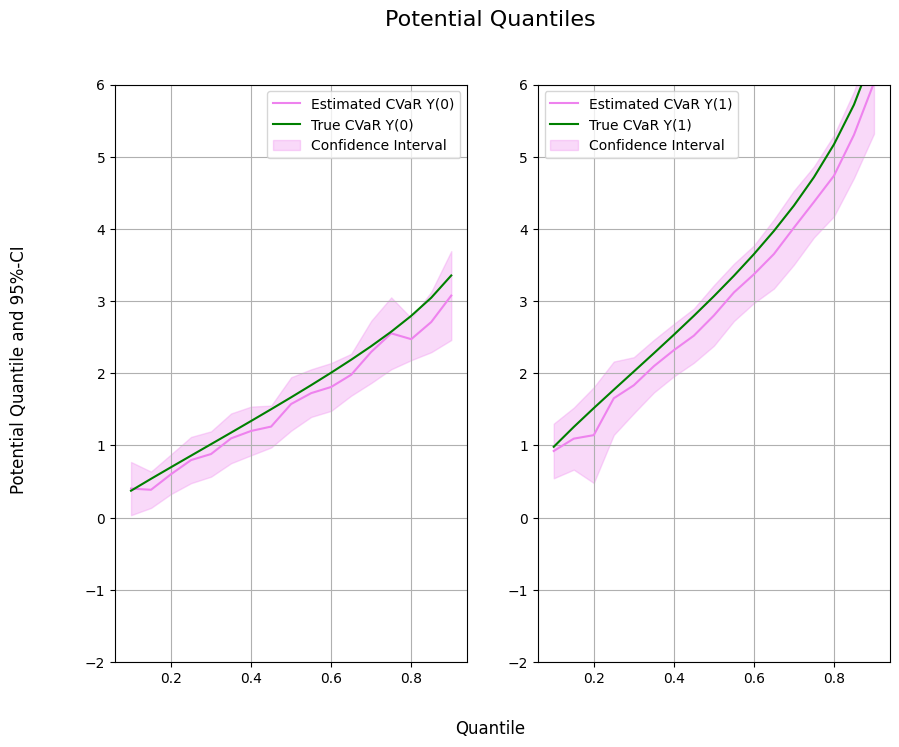

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML CVaR Y(0)'], color='violet', label='Estimated CVaR Y(0)')
ax1.plot(df['Quantile'],df['CVaR Y(0)'], color='green', label='True CVaR Y(0)')
ax1.fill_between(df['Quantile'], df['DML CVaR Y(0) lower'], df['DML CVaR Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-2, 6)

ax2.plot(df['Quantile'],df['DML CVaR Y(1)'], color='violet', label='Estimated CVaR Y(1)')
ax2.plot(df['Quantile'],df['CVaR Y(1)'], color='green', label='True CVaR Y(1)')
ax2.fill_between(df['Quantile'], df['DML CVaR Y(1) lower'], df['DML CVaR Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-2, 6)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

## CVaR Treatment Effects
In most cases, we want to evaluate the treatment effect on the CVaR as the difference between potential CVaRs.
To estimate the treatment effect, we can use the `DoubleMLQTE` object and specify `CVaR` as the score. 

As for quantile treatment effects, different quantiles can be estimated in parallel with `n_jobs_models`.

In [8]:
n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

dml_CVAR = dml.DoubleMLQTE(obj_dml_data,
                           ml_g,
                           ml_m,
                           score='CVaR',
                           quantiles=tau_vec,
                           n_folds=5)
dml_CVAR.fit(n_jobs_models=n_cores-1)
print(dml_CVAR)

Number of Cores: 24
================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
          coef   std err         t         P>|t|     2.5 %    97.5 %
0.10  0.597041  0.235459  2.535651  1.122385e-02  0.135550  1.058531
0.15  0.623882  0.264366  2.359923  1.827874e-02  0.105735  1.142029
0.20  0.793610  0.269200  2.948026  3.198106e-03  0.265987  1.321233
0.25  0.868959  0.269935  3.219141  1.285753e-03  0.339896  1.398021
0.30  0.976973  0.258435  3.780336  1.566170e-04  0.470449  1.483497
0.35  0.888349  0.272688  3.257749  1.122996e-03  0.353891  1.422808
0.40  1.006829  0.259370  3.881824  1.036758e-04  0.498473  1.515184
0.45  1.142554  0.267789  4.266625  1.984526e-05  0.617698  1.667411
0.50  1.293520  0.295365  4.379394  1.190098e-05  0.714615  1.872425
0.55  1.395723  0.297079  4.698160  2.625152e-06  0.813460  1.977986
0.60  1.508527  0.303947  4.963127  6.936709e-07  0.912802  2.104252
0.65  1.438313  0.310406  4.633648  3.

As for standard `DoubleMLCVAR` objects, we can construct valid confidencebands with the `confint()` method. Additionally, it might be helpful to construct uniformly valid confidence regions via boostrap.

In [9]:
ci_CVAR = dml_CVAR.confint(level=0.95, joint=False)

dml_CVAR.bootstrap(n_rep_boot=2000)
ci_joint_CVAR = dml_CVAR.confint(level=0.95, joint=True)
ci_joint_CVAR

,2.5 %,97.5 %
0.10,0.020511,1.173570
0.15,-0.023427,1.271192
0.20,0.134462,1.452758
0.25,0.208012,1.529905
0.30,0.344183,1.609762
0.35,0.220662,1.556037
0.40,0.371751,1.641906
0.45,0.486863,1.798245
0.50,0.570307,2.016733
0.55,0.668314,2.123132


Finally, we can compare the predicted treatment effect with the true treatment effect on the CVaR.

In [10]:
CVAR = np.array(Y1_cvar) - np.array(Y0_cvar)
data = {"Quantile": tau_vec, "CVaR": CVAR, "DML CVaR": dml_CVAR.coef,
        "DML CVaR pointwise lower": ci_CVAR['2.5 %'], "DML CVaR pointwise upper": ci_CVAR['97.5 %'],
        "DML CVaR joint lower": ci_joint_CVAR['2.5 %'], "DML CVaR joint upper": ci_joint_CVAR['97.5 %']}
df = pd.DataFrame(data)
print(df)

      Quantile      CVaR  DML CVaR  DML CVaR pointwise lower  \
0.10      0.10  0.608666  0.597041                  0.135550   
0.15      0.15  0.718240  0.623882                  0.105735   
0.20      0.20  0.818145  0.793610                  0.265987   
0.25      0.25  0.913019  0.868959                  0.339896   
0.30      0.30  1.005794  0.976973                  0.470449   
0.35      0.35  1.098805  0.888349                  0.353891   
0.40      0.40  1.194121  1.006829                  0.498473   
0.45      0.45  1.293757  1.142554                  0.617698   
0.50      0.50  1.399726  1.293520                  0.714615   
0.55      0.55  1.514606  1.395723                  0.813460   
0.60      0.60  1.641307  1.508527                  0.912802   
0.65      0.65  1.783765  1.438313                  0.829928   
0.70      0.70  1.947502  1.966876                  1.316242   
0.75      0.75  2.140358  2.188473                  1.493792   
0.80      0.80  2.375082  2.226788      

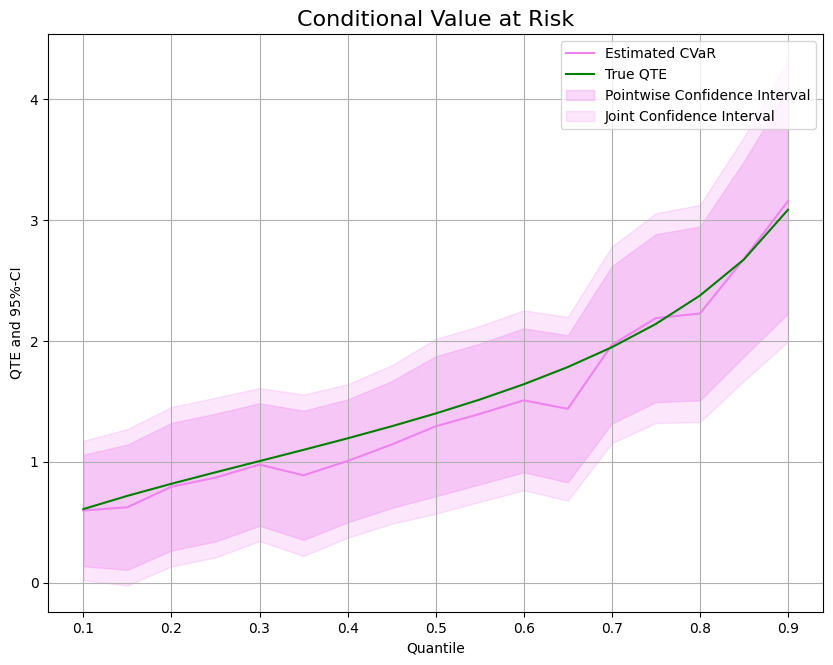

In [11]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df['Quantile'],df['DML CVaR'], color='violet', label='Estimated CVaR')
ax.plot(df['Quantile'],df['CVaR'], color='green', label='True QTE')
ax.fill_between(df['Quantile'], df['DML CVaR pointwise lower'], df['DML CVaR pointwise upper'], color='violet', alpha=.3, label='Pointwise Confidence Interval')
ax.fill_between(df['Quantile'], df['DML CVaR joint lower'], df['DML CVaR joint upper'], color='violet', alpha=.2, label='Joint Confidence Interval')

plt.legend()
plt.title('Conditional Value at Risk', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')